In [43]:
from sympy import false
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision import datasets
import torch
import torchvision.models as models
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

In [44]:
googlenet = models.googlenet(weights=None, init_weights=True)

In [45]:
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [46]:
image_size = 224
train_data = datasets.Flowers102(
    root='data',
    split='train',
    transform = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),]),
    download=False
)

# Flowers102 데이터셋 다운로드 및 로드 (테스트 데이터)
test_data = datasets.Flowers102(
    root='data',
    split='test',
    transform = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),]),
    download=False
)

In [47]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [48]:
googlenet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [49]:
hyper_parameters = {}
hyper_parameters['batch_size'] = 64
hyper_parameters['epochs'] = 50
hyper_parameters['lr'] = 1e-3
hyper_parameters['weight_decay'] = 1e-3
hyper_parameters['loss_fn'] = nn.CrossEntropyLoss()

In [50]:
train_loader = DataLoader(train_data, batch_size=hyper_parameters['batch_size'], shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=hyper_parameters['batch_size'], shuffle=False, num_workers=8)

In [51]:
def train_loop(dataloader, model, loss_fn, optimizer, show_step=False):
    size = len(dataloader.dataset)
    model.train()
    ls = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred.logits, y)  # 메인 로짓 사용

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
    return ls

def test_loop(dataloader, model, loss_fn, show_step=False):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # 평가 모드에서는 텐서 반환
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if show_step:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [52]:
def loop_epoch(epoch, train_loader, test_loader, model, loss_fn, optimizer):
    acc_history = []
    for t in range(epoch):
        train_loop(train_loader, model, loss_fn, optimizer)
        acc = test_loop(test_loader, model, loss_fn)
        acc_history.append(acc)

        # 그래프 그리기
        plt.clf()
        if t > 0:  # t가 0보다 클 때만 그래프를 그림
            plt.plot(range(1, t + 2), acc_history, marker='o')  # x 범위를 1부터 t+2까지로 조정
            plt.title(f"Accuracy over epochs({hyper_parameters})")
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()
    print("Done!")
    return acc_history

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=hyper_parameters['lr'], weight_decay=hyper_parameters['weight_decay'])

 Epoch 2 running

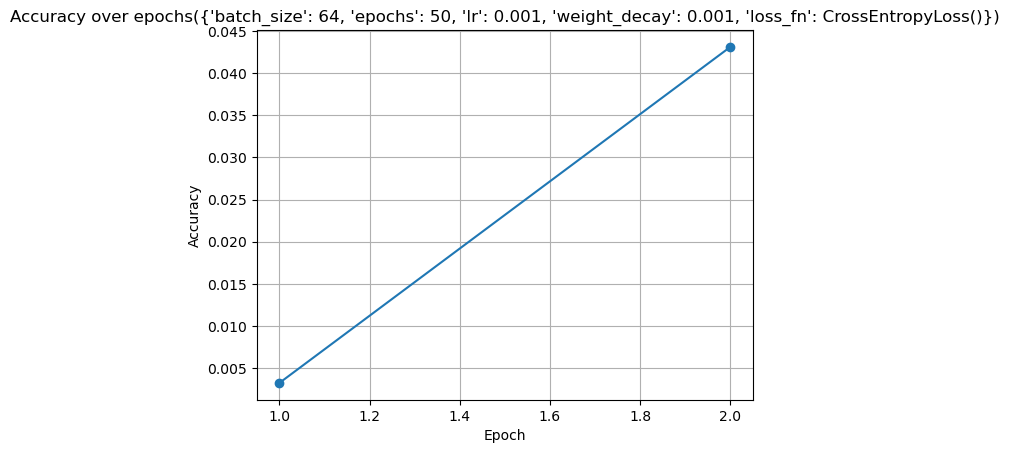

 Epoch 3 running

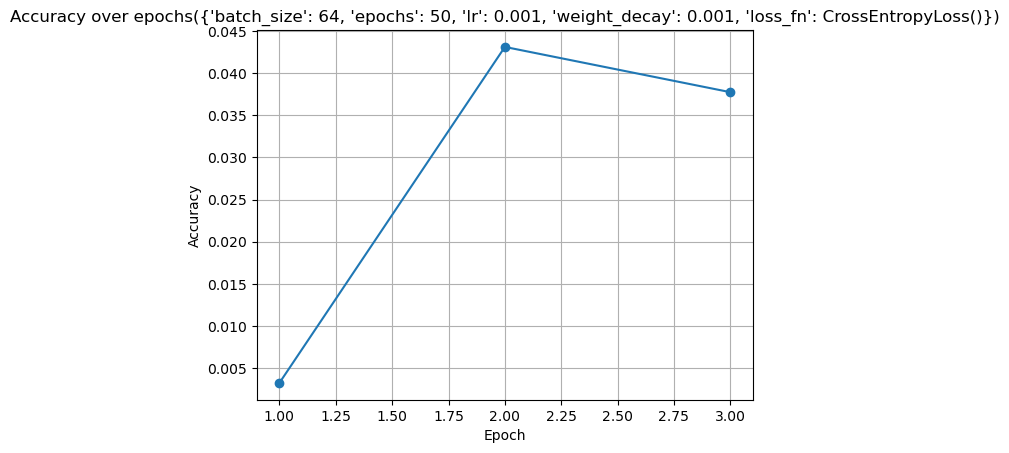

 Epoch 4 running

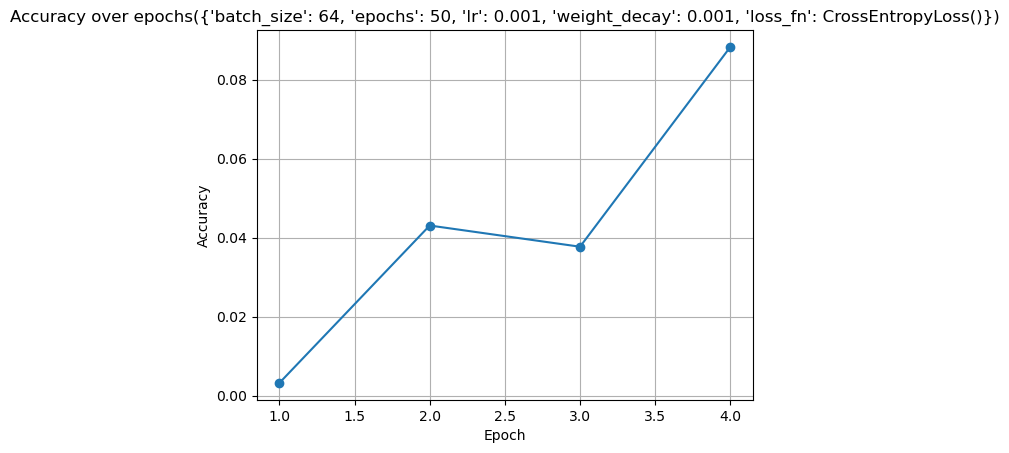

 Epoch 5 running

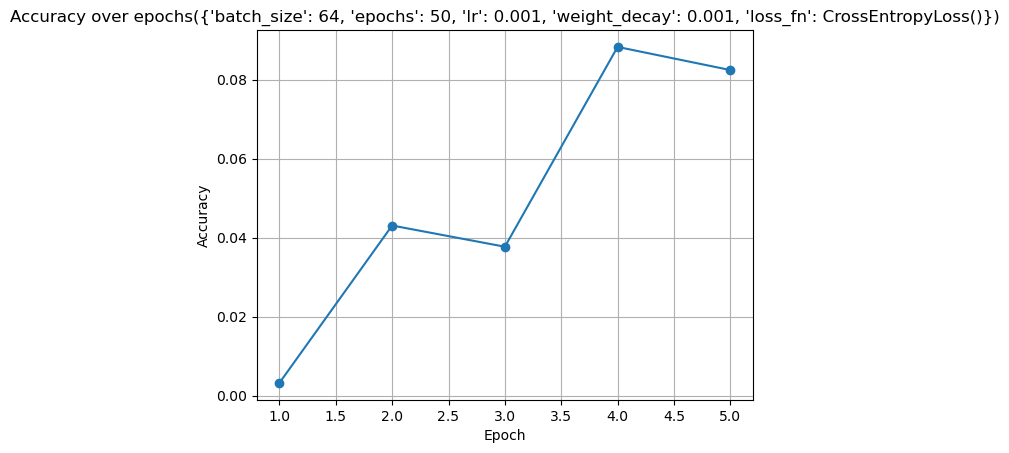

 Epoch 6 running

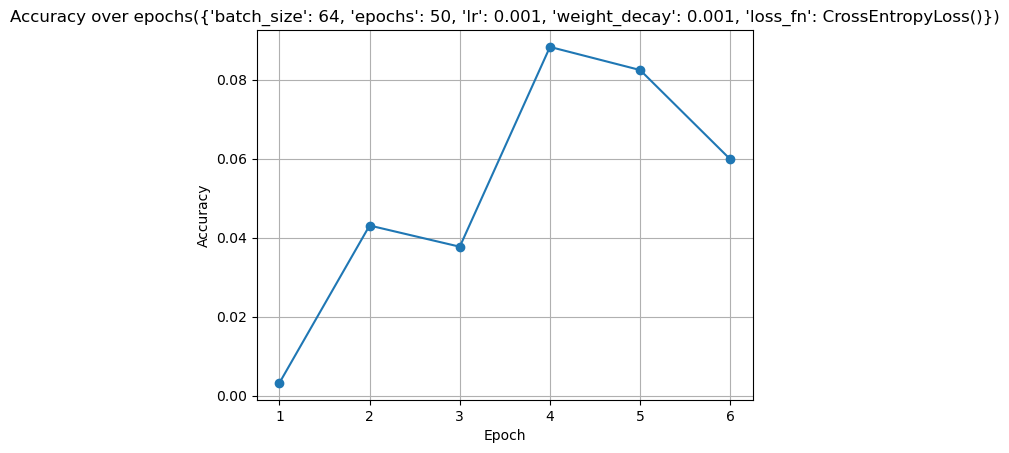

 Epoch 7 running

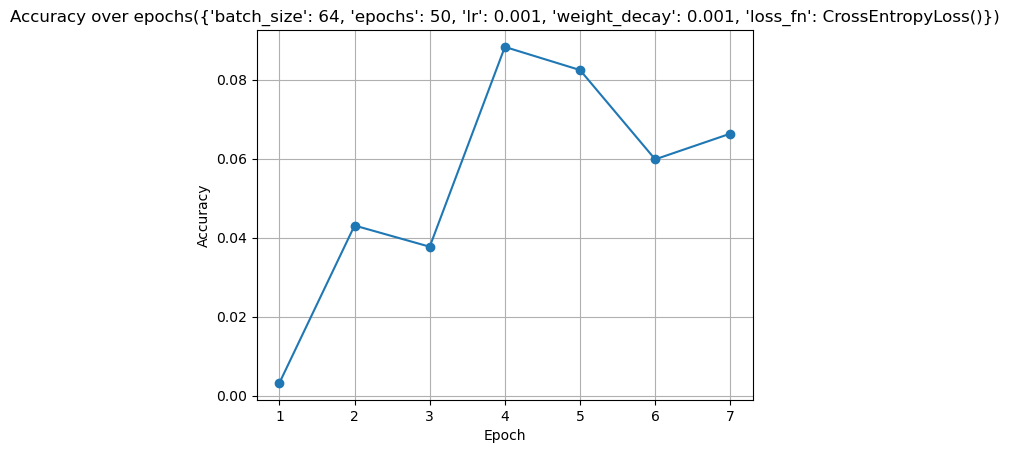

 Epoch 8 running

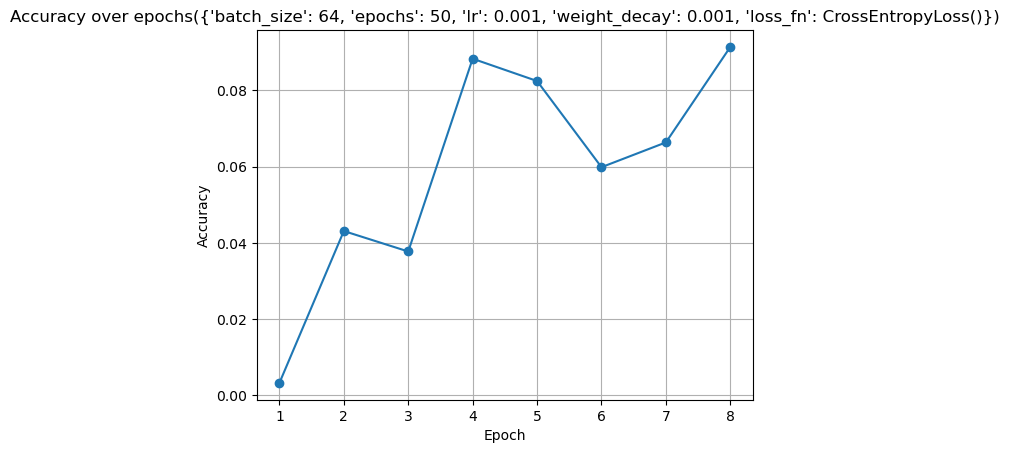

 Epoch 9 running

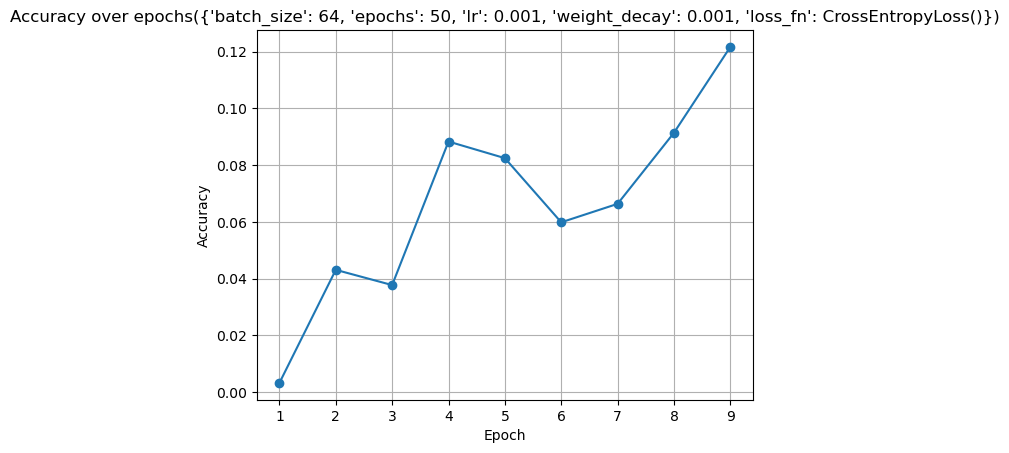

 Epoch 10 running

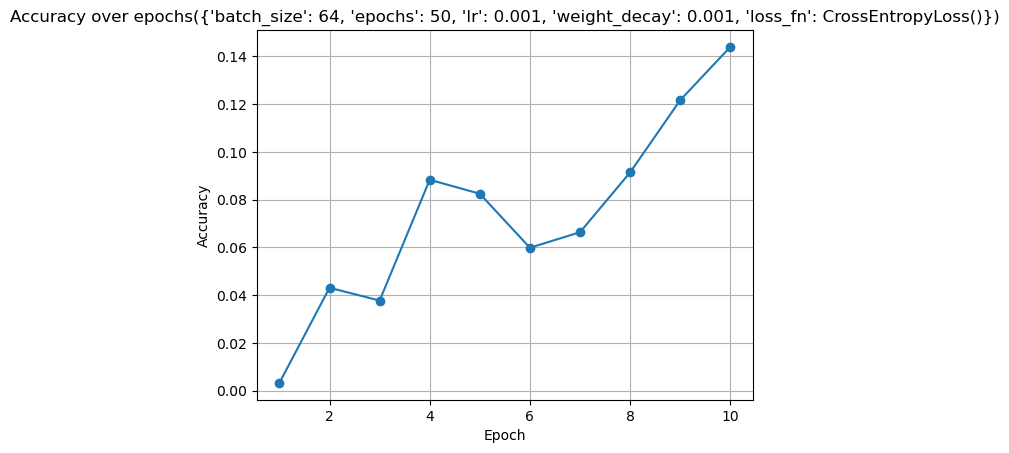

 Epoch 11 running

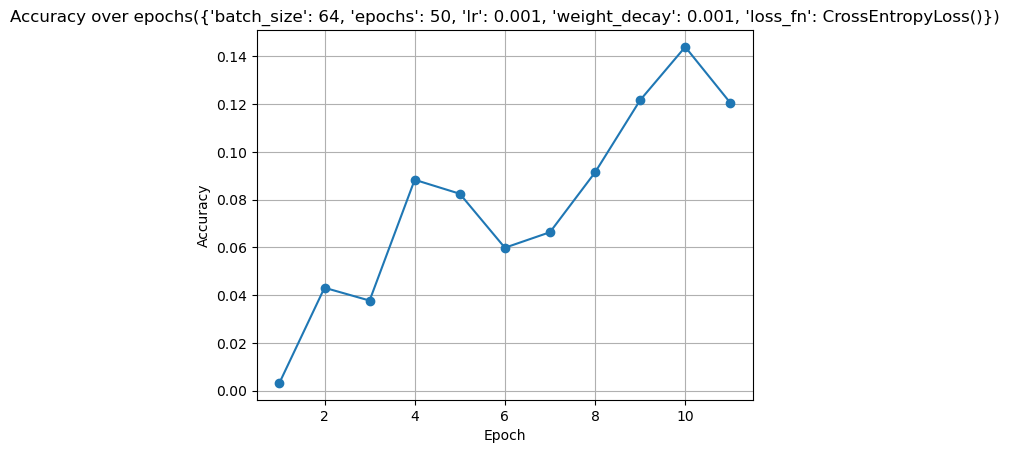

 Epoch 12 running

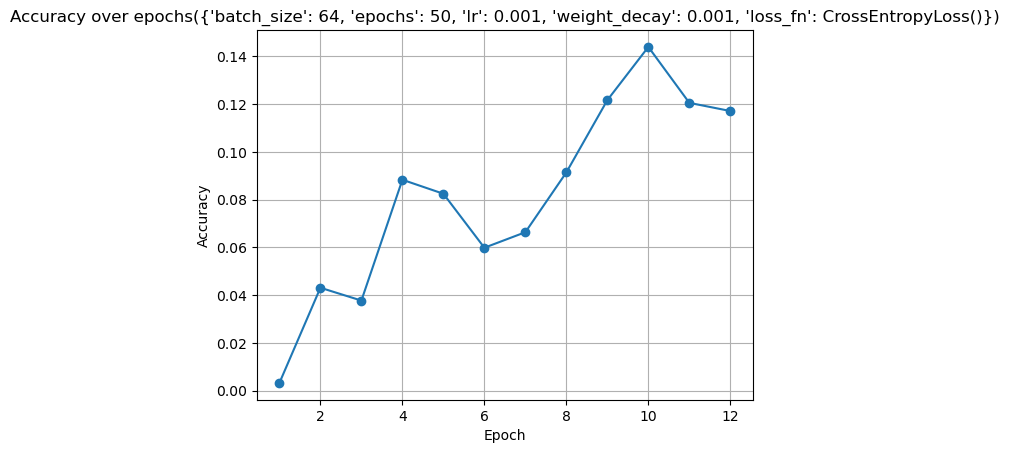

 Epoch 13 running

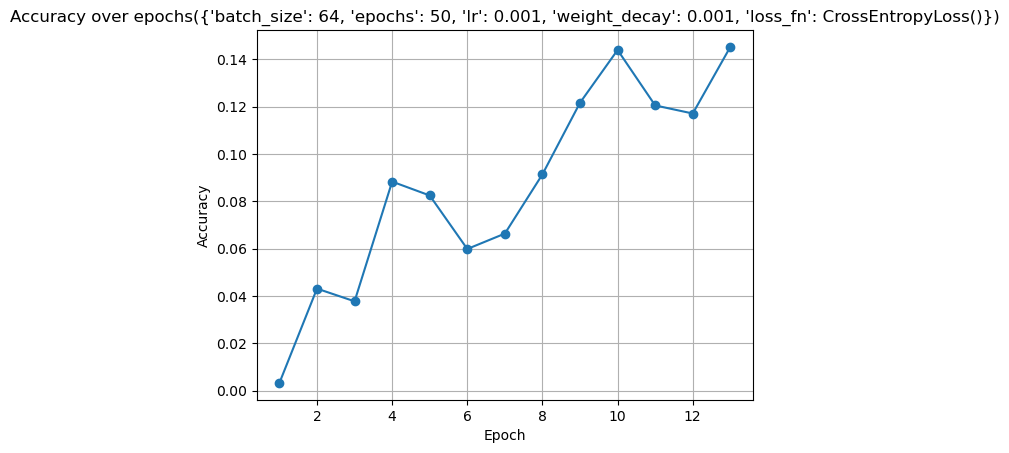

 Epoch 14 running

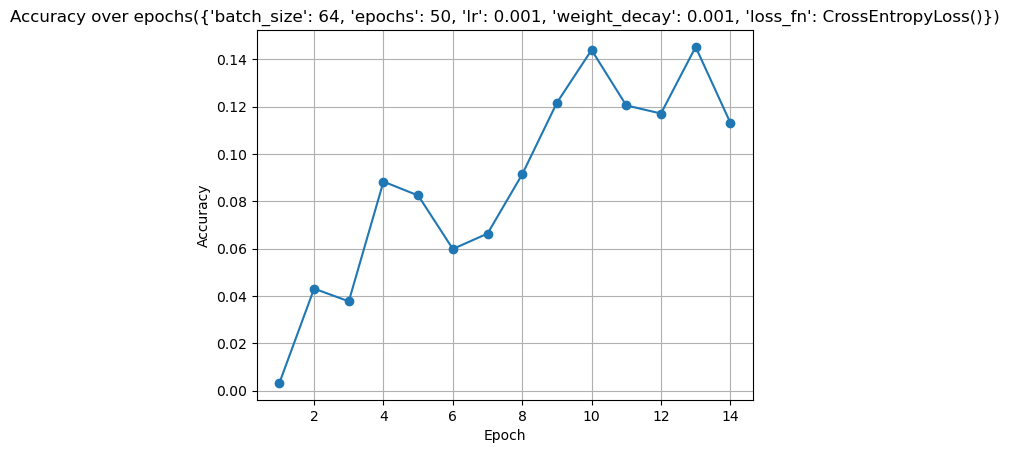

 Epoch 15 running

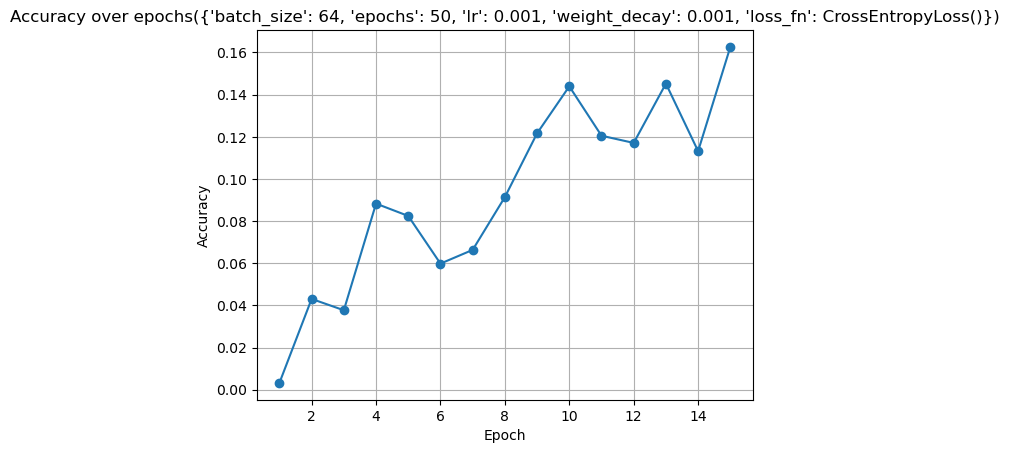

 Epoch 16 running

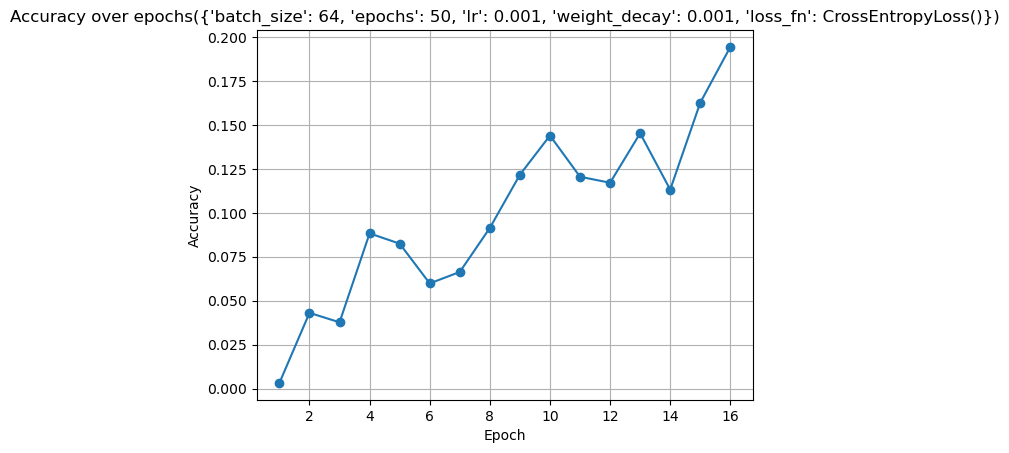

 Epoch 17 running

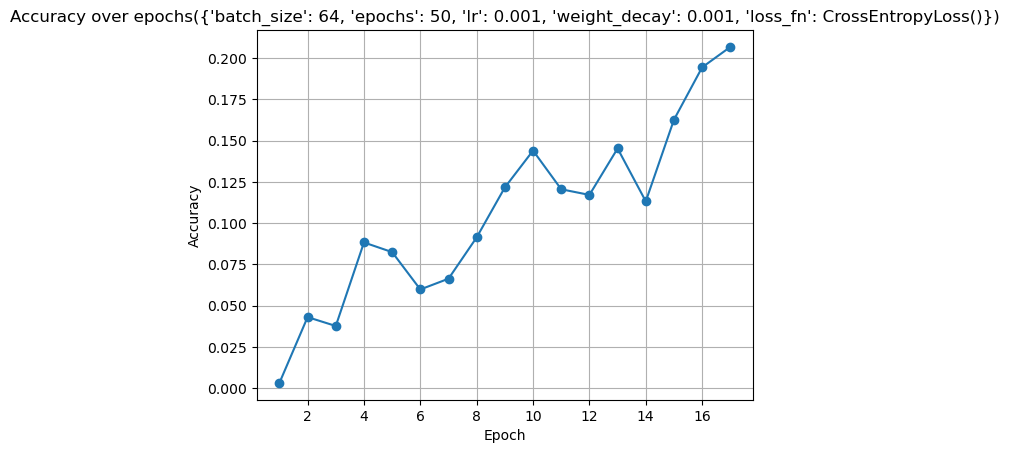

 Epoch 18 running

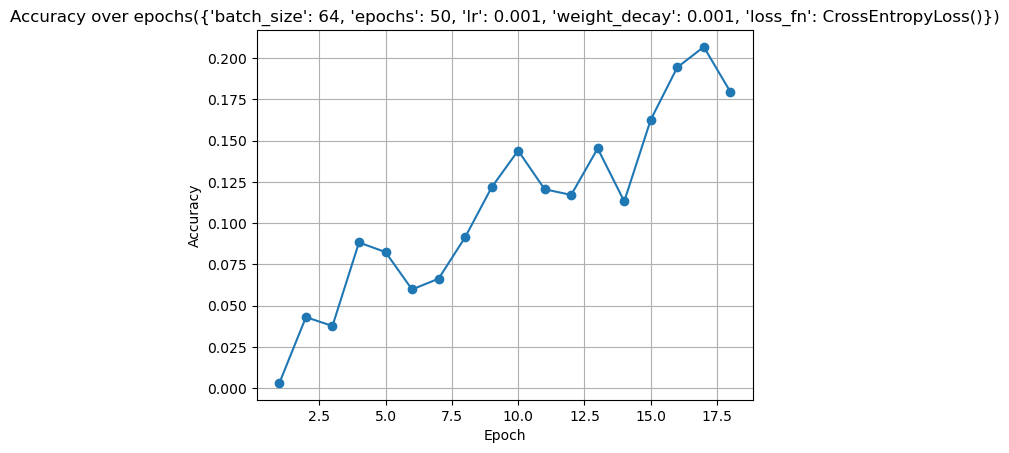

 Epoch 19 running

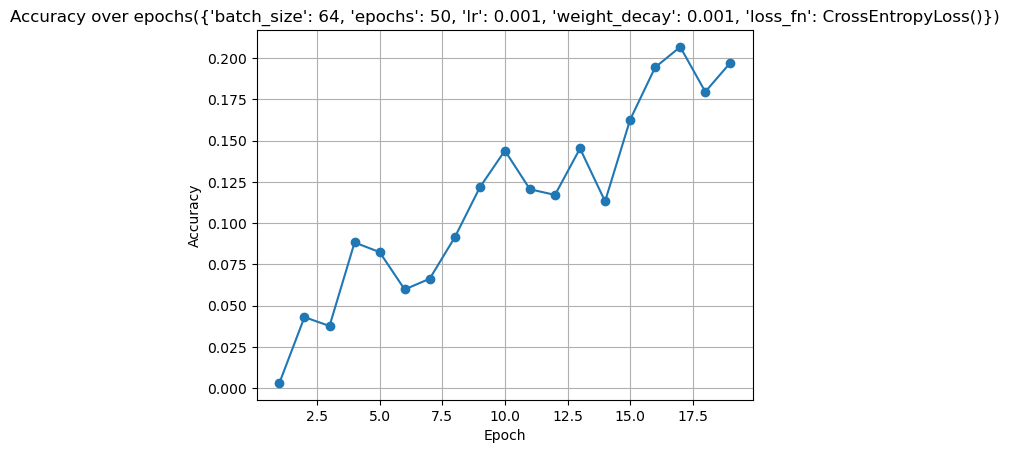

 Epoch 20 running

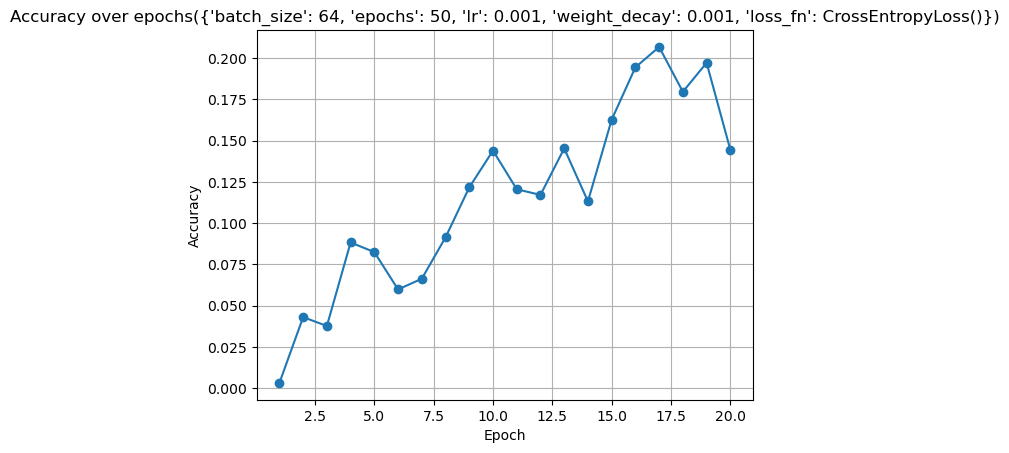

 Epoch 21 running

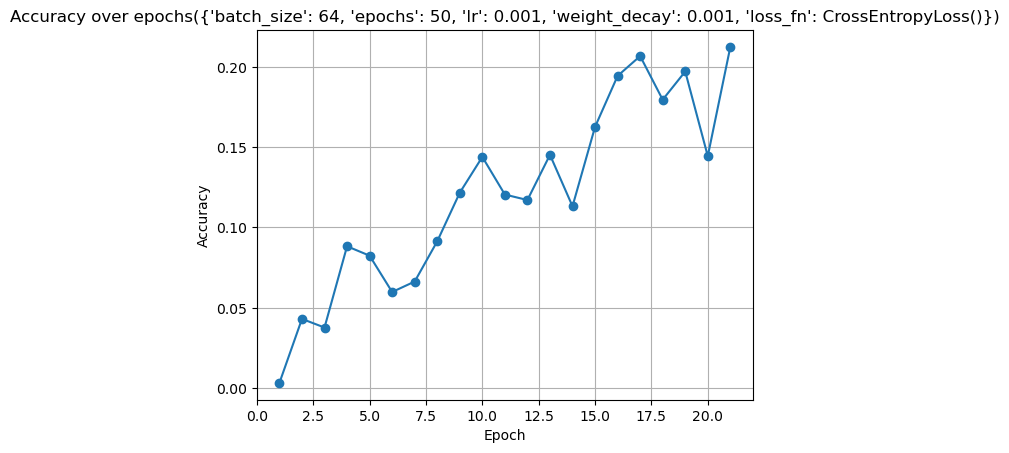

 Epoch 22 running

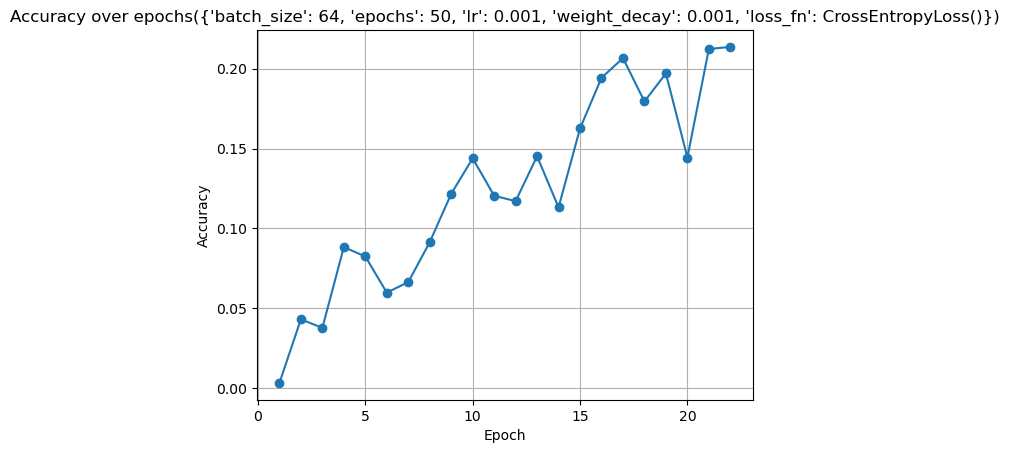

 Epoch 23 running

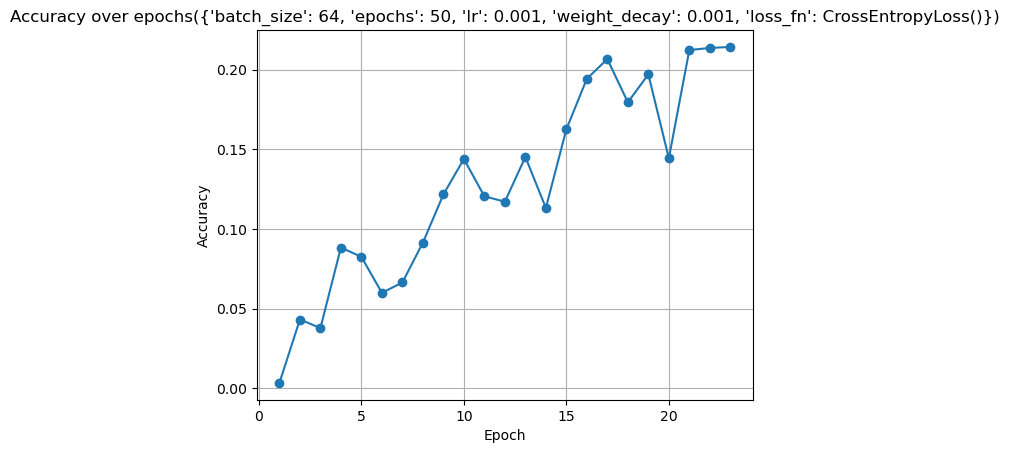

 Epoch 24 running

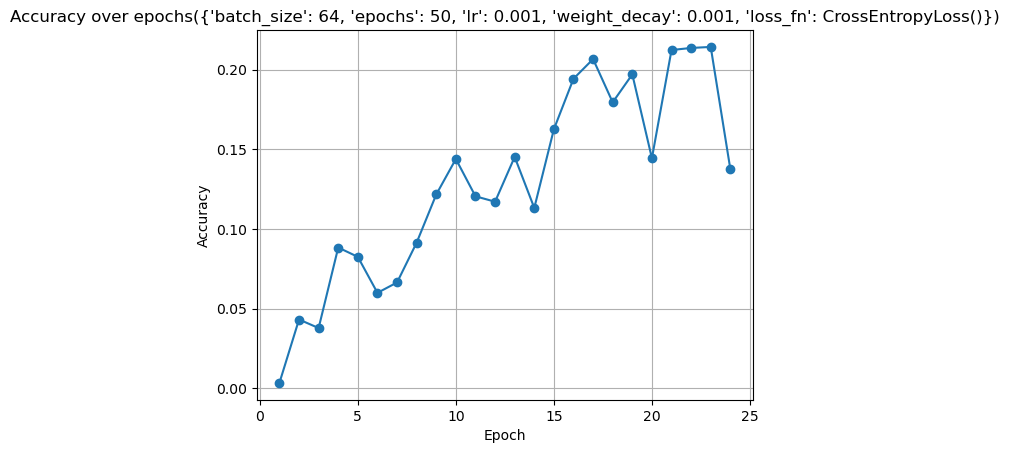

 Epoch 25 running

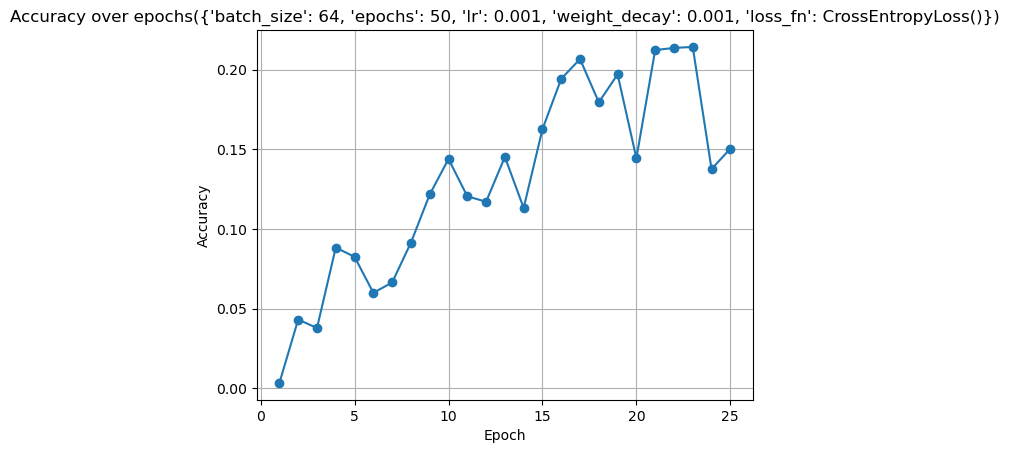

 Epoch 26 running

KeyboardInterrupt: 

In [54]:
acc_history = loop_epoch(hyper_parameters['epochs'], train_loader, test_loader, googlenet, hyper_parameters['loss_fn'], optimizer, show_step=false)

flower_102에서는 inception을 사용했었는데 당시 acc = 0.14정도 였고<br>
googlenet에서는 0.2정도였던걸 고려했을 때<br>
rcnn을 적용해 개선해야할 것으로 보임